
Rodolfo Cota Borbon: 301288986
Eman Abubakr: 301171599

# Assignment 5: Autoencoders

In [9]:
from sklearn.datasets import fetch_olivetti_faces
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
import numpy as np
from sklearn.decomposition import PCA
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from sklearn.model_selection import KFold,  ParameterSampler
import matplotlib.pyplot as plt

1. Use the training set, validation set, and test set from Assignment 3 (Hierarchical Clustering) for this Assignment.

In [5]:
"""1.1 Retrieve and load the Olivetti faces dataset"""
from sklearn.datasets import fetch_olivetti_faces

faces = fetch_olivetti_faces(random_state=42)

# Print dataset details
print('Dataset keys:', faces.keys())
print('Data shape:', faces.data.shape)  # 400 images of faces (64x64 pixels)
print('Images shape:', faces.images.shape)
print('Target shape:', faces.target.shape)  # 400 labels (0-39 for 40 individuals)
print('Target numbers:', np.unique(faces.target))
print(f'Number of images in the dataset: {len(faces.data)}')
print(f'Unique targets in the dataset: {len(np.unique(faces.target))}')

Dataset keys: dict_keys(['data', 'images', 'target', 'DESCR'])
Data shape: (400, 4096)
Images shape: (400, 64, 64)
Target shape: (400,)
Target numbers: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39]
Number of images in the dataset: 400
Unique targets in the dataset: 40


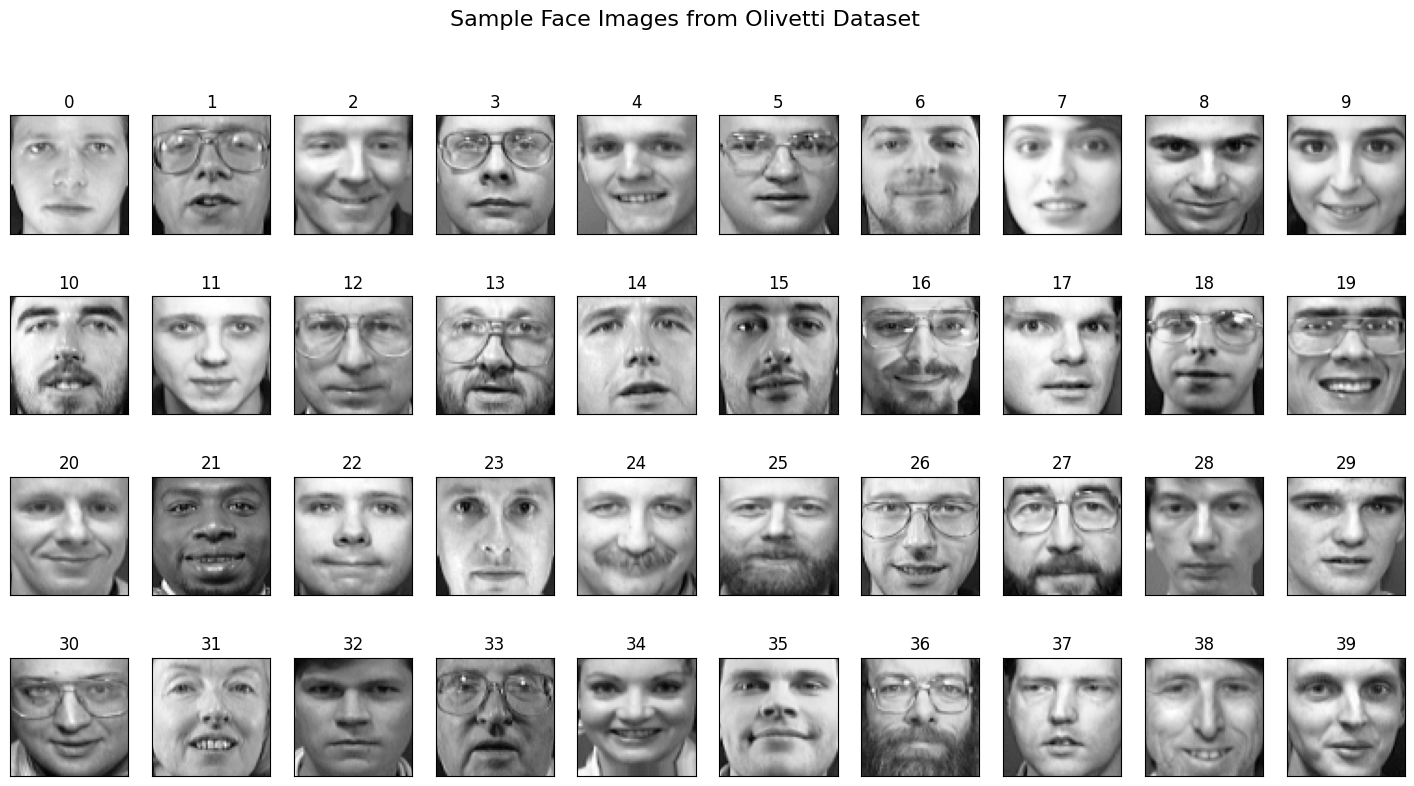

In [7]:
# Visualize a sample of face images
def face_images(data, labels):
    fig, axs = plt.subplots(nrows=4, ncols=10, figsize=(18, 9))
    axs = axs.flatten()
    for p in range(0, 40):
        I = p * 10
        pid = labels[I]
        axs[pid].imshow(data[I], cmap='gray')
        axs[pid].set_title(f"{pid}")
        axs[pid].set_xticks([])
        axs[pid].set_yticks([])

face_images(faces.images, faces.target)
plt.suptitle('Sample Face Images from Olivetti Dataset', fontsize=16)
plt.show()

In [10]:
"""
1.2 The dataset was split into 60% training, 20% validation, and 20% test sets using StratifiedShuffleSplit,
ensuring equal representation of all 40 individuals across all splits.
A 60-20-20 split is used, as it provides a good balance between model training and performance evaluation.
"""
X, y = faces.data, faces.target  # X contains images, y contains labels
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=99)
train_idx, test_idx = next(sss.split(X, y))
X_train, X_test = X[train_idx], X[test_idx]
y_train, y_test = y[train_idx], y[test_idx]

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.25, random_state=99)
train_idx, val_idx = next(sss.split(X_train, y_train))
X_train, X_val = X_train[train_idx], X_train[val_idx]
y_train, y_val = y_train[train_idx], y_train[val_idx]

print('Training shape:', X_train.shape, y_train.shape)
print('Validation shape:', X_val.shape, y_val.shape)
print('Test shape:', X_test.shape, y_test.shape)

Training shape: (240, 4096) (240,)
Validation shape: (80, 4096) (80,)
Test shape: (80, 4096) (80,)


2. Use PCA preserving 99% of the variance to reduce the dataset’s dimensionality as in Assignment 4 (Gaussian Mixture Models) and use it to train the autoencoder.

In [12]:
# Perform PCA with 99% variance explained and whitening
pca = PCA(0.99, whiten=True)

# Transform the training data
X_train_pca = pca.fit_transform(X_train)

# Transform the validation data
X_val_pca = pca.transform(X_val)

# Transform the test data
X_test_pca = pca.transform(X_test)


In [13]:
# Print the number of components selected by PCA to preserve 99% variance
print(f"Number of PCA components to preserve 99% variance: {pca.n_components_}")

Number of PCA components to preserve 99% variance: 176


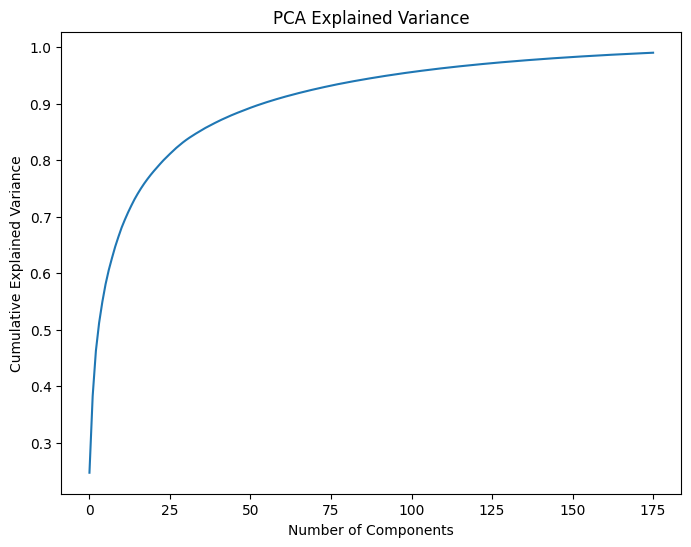

In [14]:
# Plot explained variance ratio
plt.figure(figsize=(8, 6))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("PCA Explained Variance")
plt.show()

3. Define an autoencoder

In [15]:
"""
Rationale:
- Activation Functions: ReLU is chosen for the encoding and decoding layers to introduce non-linearity, allowing the autoencoder to learn more complex representations.
The sigmoid activation in the output layer ensures reconstructed pixel values remain in the [0,1] range.
- Loss Function: MSE (Mean Squared Error) is used as it directly measures the reconstruction accuracy by computing pixel-wise differences, which is ideal for image reconstruction.
"""
# Generalized autoencoder architecture
def build_autoencoder(input_dim = 4096, encoding_dim = 32, hidden_units = (1, 1), reg = 1, lr = 0.1):
    input_layer = Input(shape=(input_dim,))
    hidden_1 = Dense(hidden_units[0], activation='relu', kernel_regularizer=l2(reg))(input_layer)
    encoded = Dense(encoding_dim, activation='relu', kernel_regularizer=l2(reg))(hidden_1)
    hidden_3 = Dense(hidden_units[1], activation='relu', kernel_regularizer=l2(reg))(encoded)
    output_layer = Dense(input_dim, activation='sigmoid')(hidden_3)

    autoencoder = Model(inputs=input_layer, outputs=output_layer)
    autoencoder.compile(optimizer=Adam(learning_rate=lr), loss='mse')
    return autoencoder

* a) Use k-fold cross validation to fine tune the model’s learning rate and hyperparameter of the regularizer.  Due to the long training requirements, for the number of hidden units, try two or three different values for each hidden layer.

In [16]:
# Define the parameter ranges
param_distributions = {
    'learning_rate': np.logspace(-5, -1, 100),  # 100 values between 0.00001 and 0.1
    'regularization': np.logspace(-4, -1, 100),  # 100 values between 0.0001 and 0.1
    'hidden_units': [(64, 64), (128, 128), (256, 256), (512, 512)]
}

# Sample 20 random combinations of hyperparameters
n_iter_search = 200
random_search = ParameterSampler(param_distributions, n_iter=n_iter_search, random_state=86) # ParameterSampler allows you to test random values from the specified ranges in param_distributions

In [ ]:
# Define K-fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=86)

# Dictionary to store results
results = []

# Iterate over the sampled parameter combinations
for params in random_search:
    lr = params['learning_rate']
    reg = params['regularization']
    hidden_units = params['hidden_units']
    fold_scores = []
    print(f"Training with lr={lr}, reg={reg}, hidden_units={hidden_units}")

    # K-fold cross-validation
    for train_index, val_index in kf.split(X_train_pca):
        X_train_fold, X_val_fold = X_train_pca[train_index], X_train_pca[val_index]

        # Build the autoencoder model with current hyperparameters
        autoencoder = build_autoencoder(input_dim=X_train_pca.shape[1], encoding_dim=32,
                                        hidden_units=hidden_units, reg=reg, lr=lr)

        # Train the model
        history = autoencoder.fit(
            X_train_fold, X_train_fold,
            epochs=10,  # Reduced epochs for quick testing
            batch_size=32,
            validation_data=(X_val_fold, X_val_fold),
            verbose=0
        )

        # Record the validation loss
        val_loss = history.history['val_loss'][-1]
        fold_scores.append(val_loss)

    # Calculate the average validation loss across folds
    avg_val_loss = np.mean(fold_scores)
    results.append({
        'learning_rate': lr,
        'regularization': reg,
        'hidden_units': hidden_units,
        'avg_val_loss': avg_val_loss
    })
    print(f"Avg validation loss for lr={lr}, reg={reg}, hidden_units={hidden_units}: {avg_val_loss}")


Training with lr=0.00019630406500402724, reg=0.0004037017258596554, hidden_units=(64, 64)
Avg validation loss for lr=0.00019630406500402724, reg=0.0004037017258596554, hidden_units=(64, 64): 1.2722763776779176
Training with lr=0.0002595024211399737, reg=9.999999999999999e-05, hidden_units=(64, 64)
Avg validation loss for lr=0.0002595024211399737, reg=9.999999999999999e-05, hidden_units=(64, 64): 1.1984239578247071
Training with lr=0.015556761439304723, reg=0.008697490026177835, hidden_units=(64, 64)
Avg validation loss for lr=0.015556761439304723, reg=0.008697490026177835, hidden_units=(64, 64): 1.0001145601272583
Training with lr=0.010722672220103242, reg=0.00016297508346206434, hidden_units=(128, 128)
Avg validation loss for lr=0.010722672220103242, reg=0.00016297508346206434, hidden_units=(128, 128): 1.0021621227264403
Training with lr=0.01707352647470692, reg=0.023101297000831605, hidden_units=(128, 128)
Avg validation loss for lr=0.01707352647470692, reg=0.023101297000831605, hidd

In [ ]:
# Find the best parameters based on average validation loss
best_params = min(results, key=lambda x: x['avg_val_loss'])
print("\nBest parameters:")
print(best_params)


Best parameters:
{'learning_rate': 0.08302175681319753, 'regularization': 0.0009326033468832199, 'hidden_units': (256, 256), 'avg_val_loss': 0.9962832212448121}


* b) Discuss the rationale with respect to the activation functions and loss function used in your model.

4. Run the best model with the test set and display the original image and the reconstructed image.

In [ ]:
# Rebuild the best model
best_autoencoder = build_autoencoder(
    input_dim=X_train_pca.shape[1],
    encoding_dim=32,
    hidden_units=best_params['hidden_units'],
    reg=best_params['regularization'],
    lr=best_params['learning_rate']
)

In [ ]:
# Train the model on the full PCA-transformed training data
history = best_autoencoder.fit(
    X_train_pca, X_train_pca,
    epochs=50,  # Use more epochs for better learning
    batch_size=32,
    validation_data=(X_val_pca, X_val_pca),
    verbose=1
)

Epoch 1/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 1.2991 - val_loss: 0.8508
Epoch 2/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.0699 - val_loss: 0.8023
Epoch 3/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.0168 - val_loss: 0.7813
Epoch 4/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.0003 - val_loss: 0.7723
Epoch 5/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.0112 - val_loss: 0.7683
Epoch 6/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.9971 - val_loss: 0.7665
Epoch 7/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.9725 - val_loss: 0.7657
Epoch 8/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.9808 - val_loss: 0.7653
Epoch 9/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.0094 - val_loss: 0.7651
Epoch 10/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.9956 - val_loss: 0.7651
Epoch 11/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.9947 - val_loss: 0.7650
Epoch 12/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.9937 - val_loss: 0.7650
Epoch 13/50


In [ ]:
# Evaluate on the PCA-transformed test set
test_loss = best_autoencoder.evaluate(X_test_pca, X_test_pca)
print(f"Test loss: {test_loss}")

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 686us/step - loss: 0.7405
Test loss: 0.7298480272293091


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


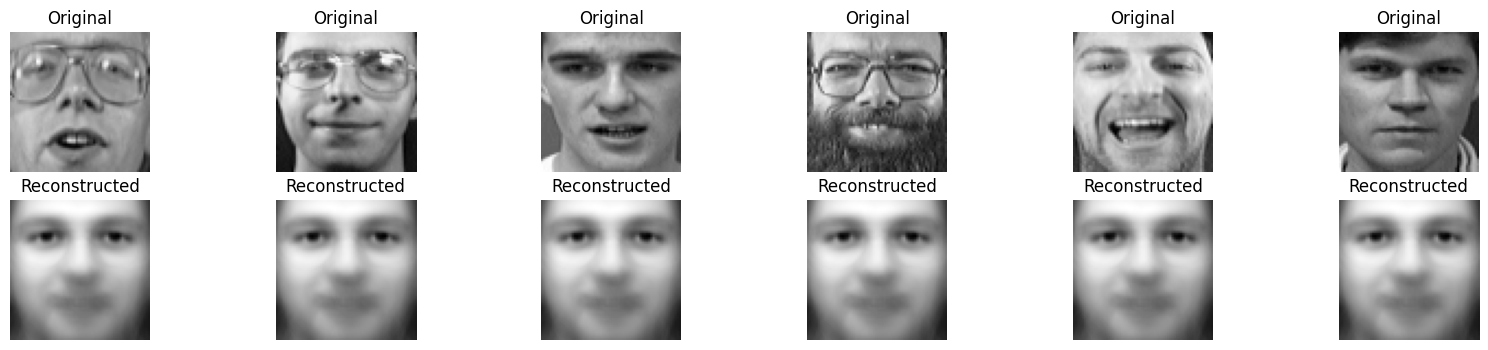

In [ ]:
# Predict the reconstructed images on the PCA-transformed test set
X_test_reconstructed_pca = best_autoencoder.predict(X_test_pca)

# Inverse transform the reconstructed images to the original space
X_test_reconstructed = pca.inverse_transform(X_test_reconstructed_pca)

# Display some of the original and reconstructed images
n = 6  # Number of images to display
plt.figure(figsize=(20, 4))

for i in range(n):
    # Display original image
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(X_test[i].reshape(64, 64), cmap="gray")
    plt.title("Original")
    plt.axis("off")

    # Display reconstructed image
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(X_test_reconstructed[i].reshape(64, 64), cmap="gray")
    plt.title("Reconstructed")
    plt.axis("off")

plt.show()